<a href="https://colab.research.google.com/github/thiennguyenuoa/ML_test/blob/main/weather_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
import csv
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn.metrics
import tensorflow as tf

from numpy import mean
from numpy import std
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import activations
from tensorflow.keras import layers

In [107]:
BATCH_SIZE = 64
MELTING_TEMPERATURE = 2
MIN_SNOW_CM = 0.5 # Above this value, we consider it as snow
NUM_EPOCHS = 100
OUTPUT_DATASET_FILE = "snow_dataset.csv"
TFL_MODEL_FILE = "snow_forecast_model.tflite"
TFL_MODEL_HEADER_FILE = "snow_forecast_model.h"
TF_MODEL = "snow_forecast"

In [108]:
!pip install wwo-hist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [84]:
from wwo_hist import retrieve_hist_data # WorldWeatherOnline

In [109]:
frequency=1
api_key = '7751d2425d9d41658b0223944222512'
location_list = ['paris']

# retrieve_hist_data returns a list of dataframe(s)
df_weather = retrieve_hist_data(api_key,
                                location_list,
                                '01-JAN-2011',
                                '31-DEC-2020',
                                frequency,
                                location_label = False,
                                export_csv = False,
                                store_df = True)



Retrieving weather data for paris


Currently retrieving data for paris: from 2011-01-01 to 2011-01-31
Time elapsed (hh:mm:ss.ms) 0:00:01.437361
Currently retrieving data for paris: from 2011-02-01 to 2011-02-28
Time elapsed (hh:mm:ss.ms) 0:00:03.119839
Currently retrieving data for paris: from 2011-03-01 to 2011-03-31
Time elapsed (hh:mm:ss.ms) 0:00:04.993503
Currently retrieving data for paris: from 2011-04-01 to 2011-04-30
Time elapsed (hh:mm:ss.ms) 0:00:06.827719
Currently retrieving data for paris: from 2011-05-01 to 2011-05-31
Time elapsed (hh:mm:ss.ms) 0:00:09.562470
Currently retrieving data for paris: from 2011-06-01 to 2011-06-30
Time elapsed (hh:mm:ss.ms) 0:00:11.487260
Currently retrieving data for paris: from 2011-07-01 to 2011-07-31
Time elapsed (hh:mm:ss.ms) 0:00:13.236914
Currently retrieving data for paris: from 2011-08-01 to 2011-08-31
Time elapsed (hh:mm:ss.ms) 0:00:15.008688
Currently retrieving data for paris: from 2011-09-01 to 2011-09-30
Time elapsed (hh:mm:ss.

In [110]:
# Extract temperature, humidity and precipitation
t_list = df_weather[0].tempC.astype(float).to_list()
h_list = df_weather[0].humidity.astype(float).to_list()
s_list = df_weather[0].totalSnow_cm.astype(float).to_list()

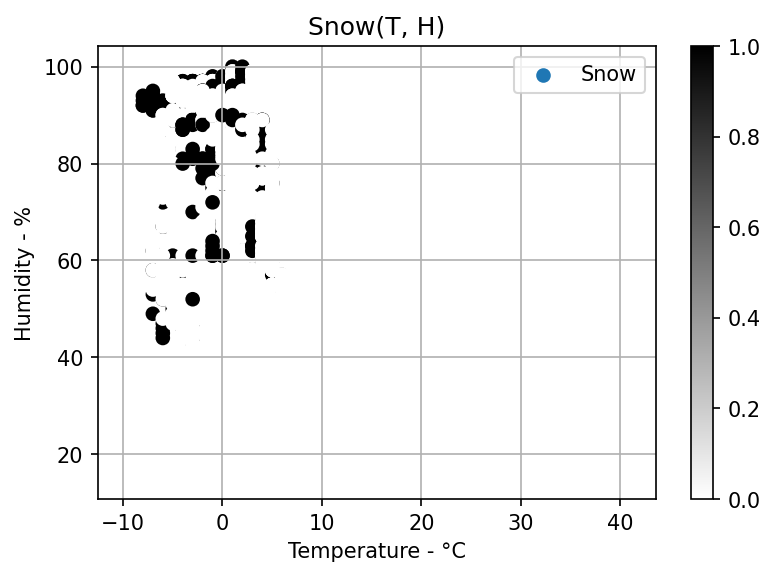

In [111]:
def binarize(snow, threshold):
  if snow > threshold:
    return 1
  else:
    return 0

s_bin_list = [binarize(snow, MIN_SNOW_CM) for snow in s_list]

cm = plt.cm.get_cmap('gray_r')
plt.figure(dpi=150)
sc = plt.scatter(t_list, h_list, c=s_bin_list, cmap=cm, label="Snow")
plt.colorbar(sc)
plt.legend()
plt.grid(True)
plt.title("Snow(T, H)")
plt.xlabel("Temperature - °C")
plt.ylabel("Humidity - %")
plt.show()

In [112]:
def gen_label(snow, temperature):
  if snow > MIN_SNOW_CM and temperature < MELTING_TEMPERATURE:
    return "Yes"
  else:
    return "No"

snow_labels = [gen_label(snow, temp) for snow, temp in zip(s_list, t_list)]

In [113]:
csv_header = ["Temp0", "Temp1", "Temp2", "Humi0", "Humi1", "Humi2", "Snow"]

df_dataset = pd.DataFrame(list(zip(t_list[:-2], t_list[1:-1], t_list[2:], h_list[:-2], h_list[1:-1], h_list[2:], snow_labels[2:])), columns = csv_header)


In [116]:
df0 = df_dataset[df_dataset['Snow'] == "No"]
df1 = df_dataset[df_dataset['Snow'] == "Yes"]

num_nosnow_samples_old = round((len(df0.index) / (len(df_dataset.index))) * 100, 2)
num_snow_samples_old   = round((len(df1.index) / (len(df_dataset.index))) * 100, 2)

# Random subsampling of the majority class to guarantee 50% split
if len(df1.index) < len(df0.index):
  df0_sub = df0.sample(len(df1.index))
  df_dataset = pd.concat([df0_sub, df1])
else:
  df1_sub = df1.sample(len(df0.index))
  df_dataset = pd.concat([df1_sub, df0])

df0 = df_dataset[df_dataset['Snow'] == "No"]
df1 = df_dataset[df_dataset['Snow'] == "Yes"]

num_nosnow_samples_new = round((len(df0.index) / (len(df_dataset.index))) * 100, 2)
num_snow_samples_new = round((len(df1.index) / (len(df_dataset.index))) * 100, 2)

# Show number of samples
df_samples_results = pd.DataFrame.from_records(
                [["% No Snow", num_nosnow_samples_old, num_nosnow_samples_new],
                ["% Snow", num_snow_samples_old, num_snow_samples_new]],
            columns = ["Class", "Before - %", "After - %"], index="Class").round(2)

display(df_samples_results)

,Before - %,After - %
Class,,
% No Snow,50.0,50.0
% Snow,50.0,50.0


In [117]:
# Get all values
t_list = df_dataset['Temp0'].tolist()
h_list = df_dataset['Humi0'].tolist()
t_list = t_list + df_dataset['Temp2'].tail(2).tolist()
h_list = h_list + df_dataset['Humi2'].tail(2).tolist()

# Calculate mean and standard deviation
t_avg = mean(t_list)
h_avg = mean(h_list)
t_std = std(t_list)
h_std = std(h_list)
print("COPY ME!")
print("Temperature - [MEAN, STD]  ", round(t_avg, 5), round(t_std, 5))
print("Humidity - [MEAN, STD]     ", round(h_avg, 5), round(h_std, 5))

# Scaling with Z-score function
def scaling(val, avg, std):
  return (val - avg) / (std)

df_dataset['Temp0'] = df_dataset['Temp0'].apply(lambda x: scaling(x, t_avg, t_std))
df_dataset['Temp1'] = df_dataset['Temp1'].apply(lambda x: scaling(x, t_avg, t_std))
df_dataset['Temp2'] = df_dataset['Temp2'].apply(lambda x: scaling(x, t_avg, t_std))
df_dataset['Humi0'] = df_dataset['Humi0'].apply(lambda x: scaling(x, h_avg, h_std))
df_dataset['Humi1'] = df_dataset['Humi1'].apply(lambda x: scaling(x, h_avg, h_std))
df_dataset['Humi2'] = df_dataset['Humi2'].apply(lambda x: scaling(x, h_avg, h_std))

COPY ME!
Temperature - [MEAN, STD]   5.46088 8.06659
Humidity - [MEAN, STD]      82.77126 13.94655


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Text(0.5, 1.0, 'Normalized humidity')

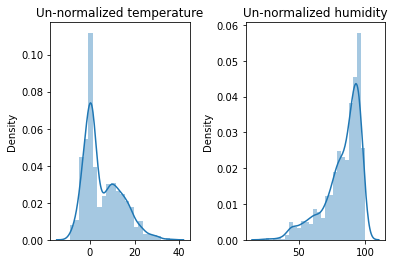

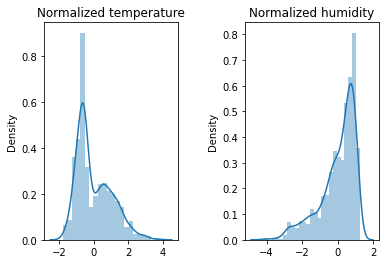

In [118]:
t_norm_list = df_dataset['Temp0'].tolist()
h_norm_list = df_dataset['Humi0'].tolist()
t_norm_list = t_norm_list + df_dataset['Temp2'].tail(2).tolist()
h_norm_list = h_norm_list + df_dataset['Humi2'].tail(2).tolist()

fig, ax=plt.subplots(1,2)
plt.subplots_adjust(wspace = 0.4)
sns.distplot(t_list, ax=ax[0])
ax[0].set_title("Un-normalized temperature")
sns.distplot(h_list, ax=ax[1])
ax[1].set_title("Un-normalized humidity")

fig, ax=plt.subplots(1,2)
plt.subplots_adjust(wspace = 0.5)
sns.distplot(t_norm_list, ax=ax[0])
ax[0].set_title("Normalized temperature")
sns.distplot(h_norm_list, ax=ax[1])
ax[1].set_title("Normalized humidity")

In [93]:
df_dataset.to_csv(OUTPUT_DATASET_FILE, index=False)

In [119]:
f_names = df_dataset.columns.values[0:6]
l_name  = df_dataset.columns.values[6:7]
x = df_dataset[f_names]
y = df_dataset[l_name]

In [95]:
labelencoder = LabelEncoder()
labelencoder.fit(y.Snow)
y_encoded = labelencoder.transform(y.Snow)

In [120]:
# Split 1 (85% vs 15%)
x_train, x_validate_test, y_train, y_validate_test = train_test_split(x, y_encoded, test_size=0.15, random_state = 1)
# Split 2 (50% vs 50%)
x_test, x_validate, y_test, y_validate = train_test_split(x_validate_test, y_validate_test, test_size=0.50, random_state = 3)

In [121]:
model = tf.keras.Sequential()
model.add(layers.Dense(12, activation='relu', input_shape=(len(f_names),)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 12)                84        
                                                                 
 dropout_5 (Dropout)         (None, 12)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 13        
                                                                 
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


In [122]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [123]:
history = model.fit(x_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_validate, y_validate))

Epoch 1/100
16/16 [==============================] - 1s 48ms/step - loss: 0.6830 - accuracy: 0.5065 - val_loss: 0.6748 - val_accuracy: 0.5843
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 0.6141 - accuracy: 0.6660 - val_loss: 0.6209 - val_accuracy: 0.7191
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5530 - accuracy: 0.7823 - val_loss: 0.5735 - val_accuracy: 0.7416
Epoch 4/100
16/16 [==============================] - 0s 15ms/step - loss: 0.5098 - accuracy: 0.8205 - val_loss: 0.5329 - val_accuracy: 0.7416
Epoch 5/100
16/16 [==============================] - 0s 14ms/step - loss: 0.4665 - accuracy: 0.8506 - val_loss: 0.4974 - val_accuracy: 0.7865
Epoch 6/100
16/16 [==============================] - 0s 21ms/step - loss: 0.4407 - accuracy: 0.8435 - val_loss: 0.4655 - val_accuracy: 0.7865
Epoch 7/100
16/16 [==============================] - 0s 17ms/step - loss: 0.4003 - accuracy: 0.8776 - val_loss: 0.4378 - val_accuracy: 0.8090
Epoch 8

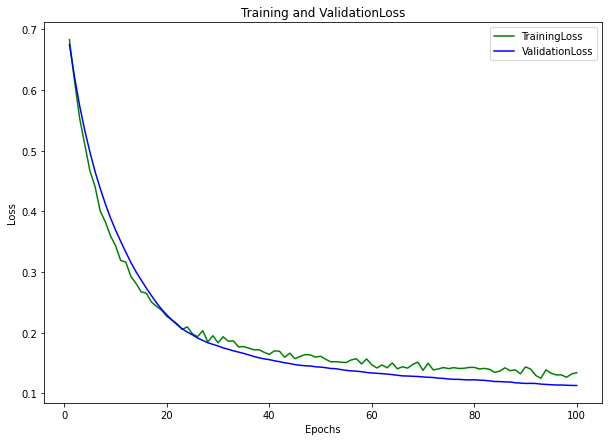

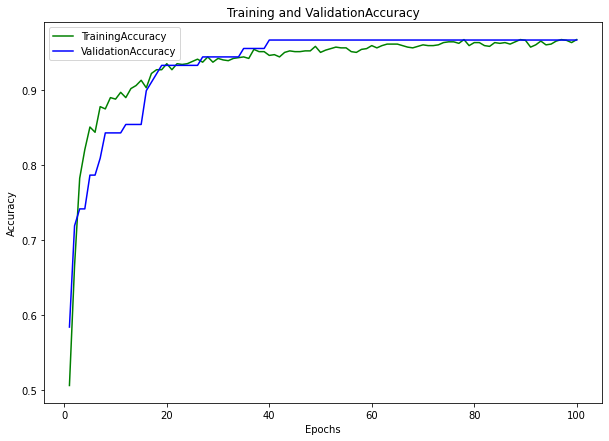

In [124]:
loss_train = history.history['loss']
loss_val   = history.history['val_loss']
acc_train  = history.history['accuracy']
acc_val    = history.history['val_accuracy']
epochs     = range(1, NUM_EPOCHS + 1)

def plot_train_val_history(x, y_train, y_val, type_txt):
  plt.figure(figsize = (10,7))
  plt.plot(x, y_train, 'g', label='Training'+type_txt)
  plt.plot(x, y_val, 'b', label='Validation'+type_txt)
  plt.title('Training and Validation'+type_txt)
  plt.xlabel('Epochs')
  plt.ylabel(type_txt)
  plt.legend()
  plt.show()

plot_train_val_history(epochs, loss_train, loss_val, "Loss")
plot_train_val_history(epochs, acc_train, acc_val, "Accuracy")

In [125]:
model.save(TF_MODEL)

3/3 [==============================] - 0s 4ms/step


<Figure size 720x504 with 0 Axes>

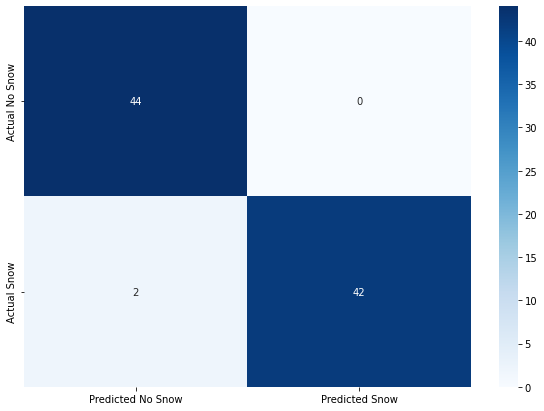

<Figure size 720x504 with 0 Axes>

In [126]:
y_test_pred = model.predict(x_test)

y_test_pred = (y_test_pred > 0.5).astype("int32")

cm = sklearn.metrics.confusion_matrix(y_test, y_test_pred)

index_names  = ["Actual No Snow", "Actual Snow"]
column_names = ["Predicted No Snow", "Predicted Snow"]

df_cm = pd.DataFrame(cm, index = index_names, columns = column_names)

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="Blues")
plt.figure(figsize = (10,7))

In [127]:
TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]

accuracy = (TP + TN) / (TP + TN + FN + FP)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f_score = (2 * recall * precision) / (recall + precision)

print("Accuracy:  ", round(accuracy, 3))
print("Recall:    ", round(recall, 3))
print("Precision: ", round(precision, 3))
print("F-score:   ", round(f_score, 3))

Accuracy:   0.977
Recall:     0.955
Precision:  1.0
F-score:    0.977


In [129]:
def representative_data_gen():
  for i_value in tf.data.Dataset.from_tensor_slices(x_test).batch(1).take(100):
    i_value_f32 = tf.dtypes.cast(i_value, tf.float32)
    yield [i_value_f32]

In [130]:
converter = tf.lite.TFLiteConverter.from_saved_model(TF_MODEL)

In [131]:
converter.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

In [132]:
tflite_model_quant = converter.convert()
open(TFL_MODEL_FILE, "wb").write(tflite_model_quant)

2104

In [133]:
!apt-get update && apt-get -qq install xxd
!xxd -i snow_forecast_model.tflite > model.h
!cat model.h

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Fetched 264 kB in 3s (77.2 kB/s)
Reading 